In [1]:
import sys
import ssl
import urllib.request
from io import StringIO

from copy import deepcopy
import os
from os import getcwd
from os.path import dirname, join
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize, basinhopping


import datetime
from sklearn import preprocessing



import csv
import json

# Load Json File
# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)




import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

SRC_DIR = 'mammal/MAMMAL' # relative path to MAMMAL library 
sys.path.append(SRC_DIR)
BASE_DIR = getcwd() # get current directory with files
DATA_DIR = join(BASE_DIR, arguments['data_dir'])
TEST_DIR = join(DATA_DIR, 'test') # directory with intermagnet data
EXAM_DIR = join(DATA_DIR, 'diurnal_test_data') # second day intermagnet data to test parameters

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu
from Utils import Filters as filt

# Create Output CSV File
out_file = open(arguments['csv_file'], mode = 'a', encoding='UTF8')

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)#

# Determine Day Ranges for Training and Testing Data Sets

In [2]:
obj = os.walk(TEST_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tra = x[0]
end_tra = x[len(x)-1]

# Do It again for Testing Data 
obj = os.walk(EXAM_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tst = x[0]
end_tst = x[len(x)-1]

# Load INTERMAGNET Data

/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/pandas-1.3.4-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loaded bou20230731qmin.min
Loaded frd20230731qmin.min
Loaded frd20230726qmin.min
Loaded bou20230726qmin.min
Loaded frd20230727qmin.min
Loaded bou20230727qmin.min
Loaded frd20230801qmin.min
Loaded bou20230801qmin.min
Loaded frd20230802qmin.min
Loaded bou20230802qmin.min
Loaded bou20230725qmin.min
Loaded frd20230725qmin.min
Loaded frd20230730qmin.min
Loaded bou20230730qmin.min
Loaded bou20230729qmin.min
Loaded frd20230729qmin.min
Loaded bou20230724qmin.min
Loaded frd20230724qmin.min
Loaded bou20230728qmin.min
Loaded frd20230728qmin.min


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 137.41it/s]


            DATE     TIME  DOY        X       Y        Z         F  \
0     2023-07-24      0.0  205  20509.4  2889.4  47071.1  51437.18   
1     2023-07-24     60.0  205  20509.4  2889.4  47071.1  51437.18   
2     2023-07-24    120.0  205  20509.1  2889.7  47071.1  51436.98   
3     2023-07-24    180.0  205  20508.9  2889.7  47071.2  51436.99   
4     2023-07-24    240.0  205  20508.4  2889.9  47071.1  51436.81   
...          ...      ...  ...      ...     ...      ...       ...   
1435  2023-08-02  86100.0  214  20503.4  2869.8  47052.4  51416.07   
1436  2023-08-02  86160.0  214  20503.4  2870.3  47052.4  51416.20   
1437  2023-08-02  86220.0  214  20503.4  2870.9  47052.5  51416.13   
1438  2023-08-02  86280.0  214  20503.9  2871.0  47052.6  51416.42   
1439  2023-08-02  86340.0  214  20504.4  2871.2  47052.6  51416.73   

                datetime     epoch_sec     LAT     LONG     ALT        IGRF_X  \
0    2023-07-24 00:00:00  1.690157e+09  40.137 -105.237  1682.0  20528.786997 

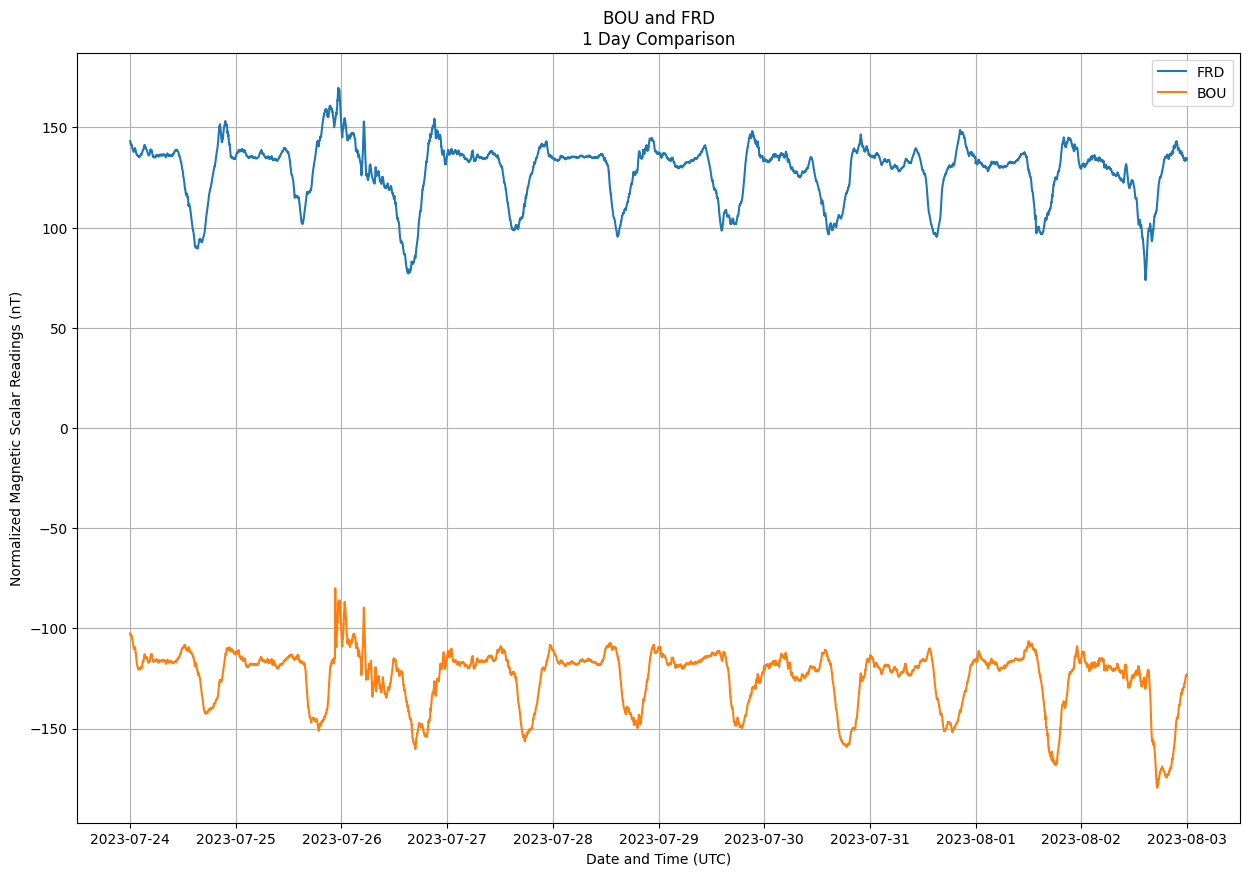

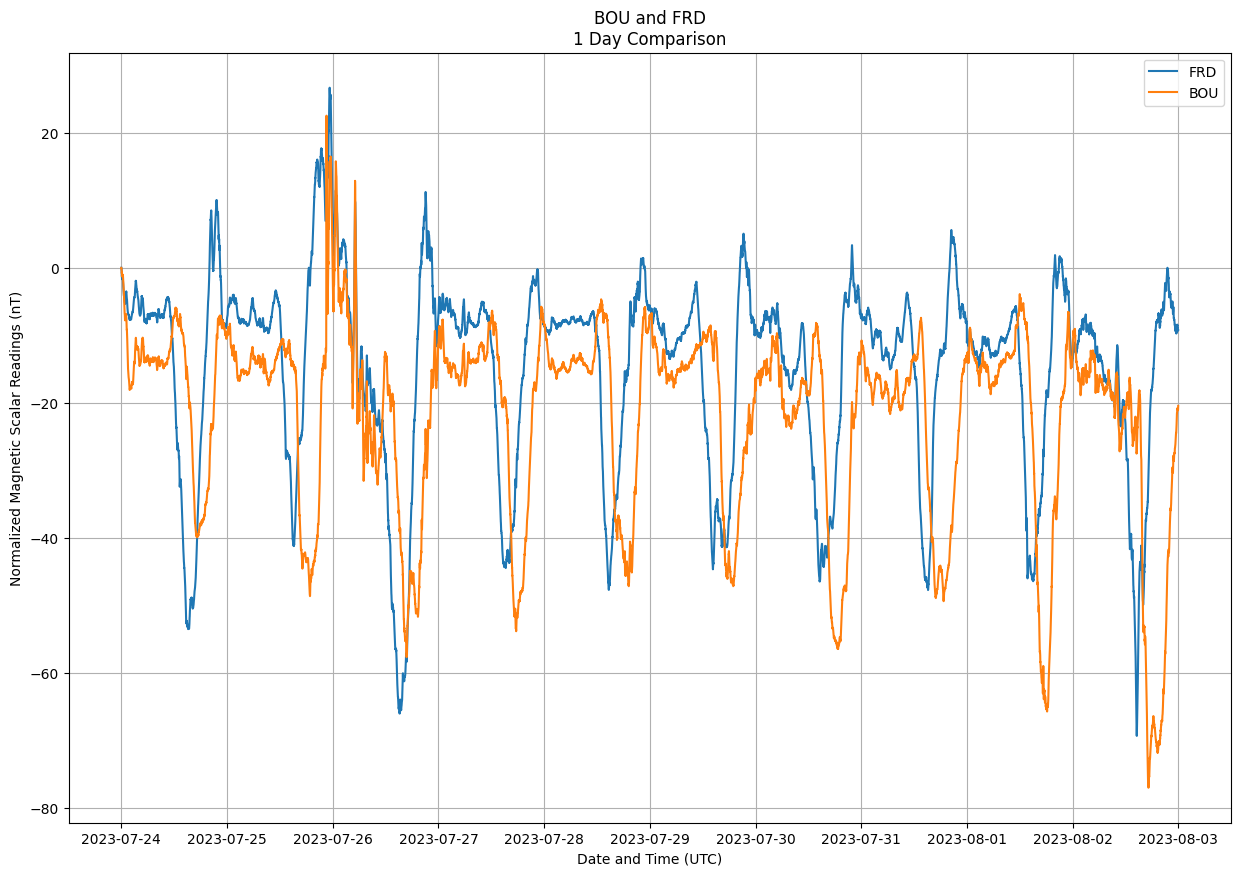

In [3]:
df_dict = pi.loadInterMagData(TEST_DIR, fast_mode = False, second = False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]


to_df = pu.reject_outliers(to_df,
                           window_size=200,
                           std_lim=3)

print(from_df)
to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
# print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

RMSE: 252.87433342203926


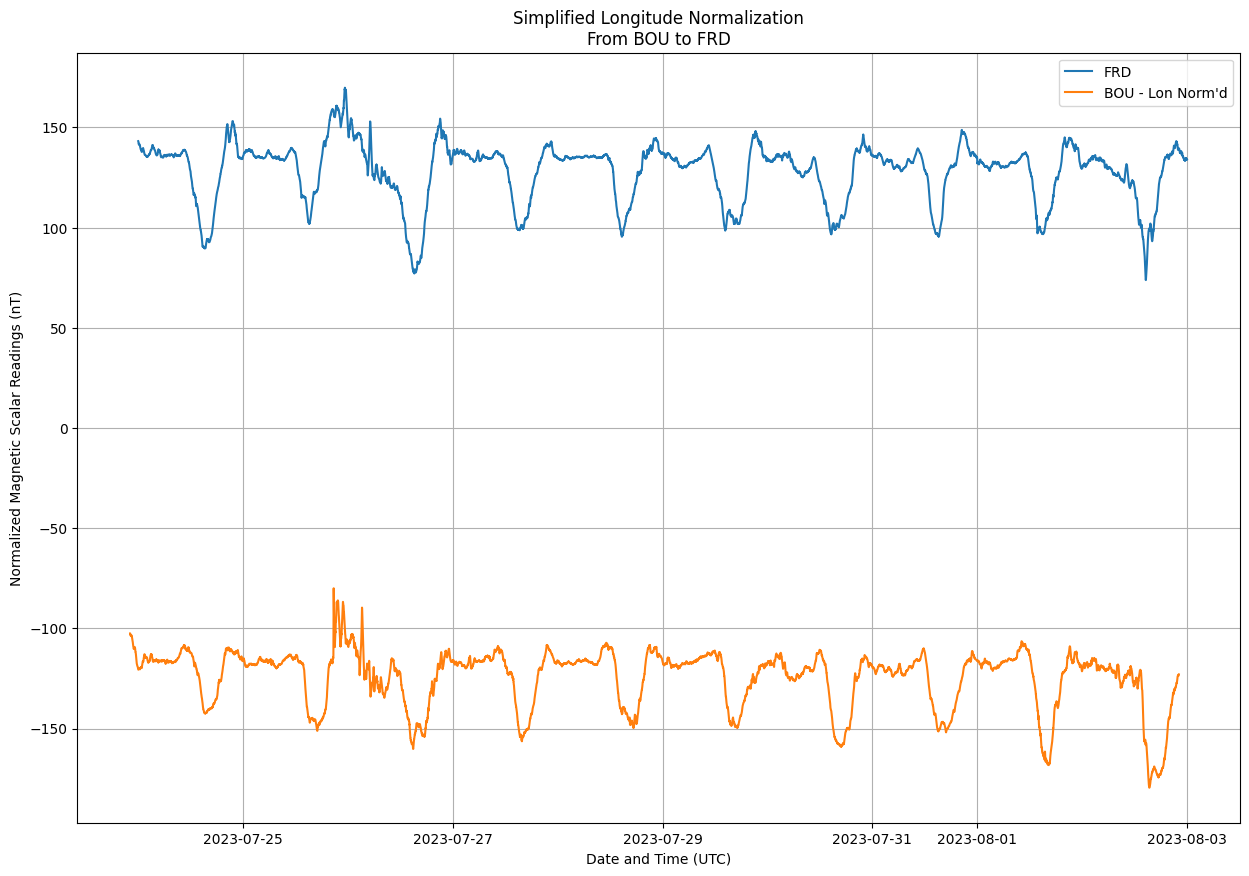

In [4]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / (Diurnal.E_ROT_DEG_S))
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

# Frequency-Based Longitude Normalization

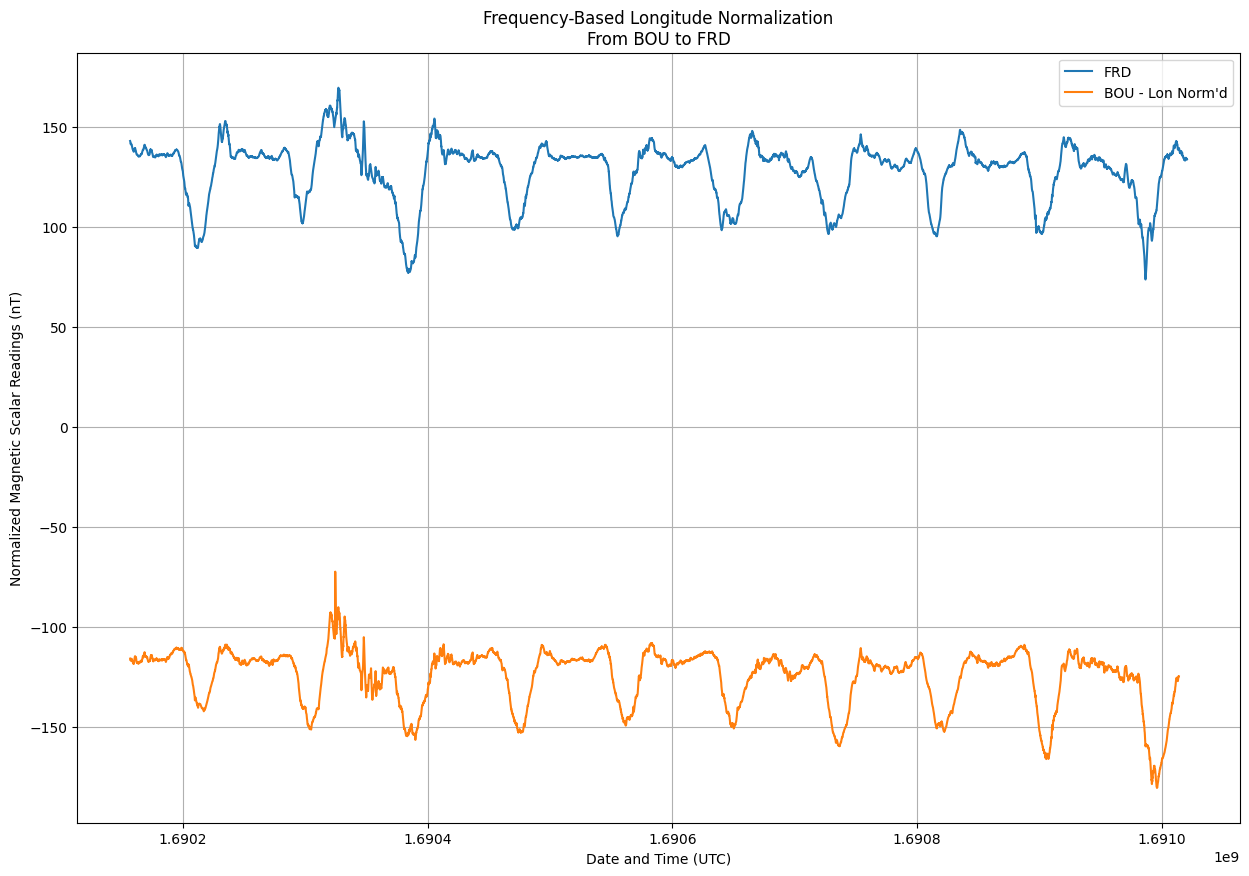

In [5]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second = False)
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
#                        from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# Neural Network Approach

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler

# create models

class ERSM_NN(nn.Module):
    __scaler = StandardScaler() # create scaler
    
    def __init__(self, n_hidden=1, d_in=4, d_out=1, d_hidden=50, drop_per=0.5, batch_size=1000):
        super(ERSM_NN, self).__init__()
        
        d_hide_out = d_in + d_hidden
        linear_ReLU_layers = []
        
        for i in range(n_hidden):
            linear_ReLU_layers.append(self.__getResLayer(d_in,d_hidden, drop_per))
            linear_ReLU_layers.append(nn.ReLU())
        
        # add output layer
#         linear_ReLU_layers.append(nn.Linear(d_in, 2*d_in))
#         linear_ReLU_layers.append(nn.BatchNorm1d(2*d_in))
#         linear_ReLU_layers.append(nn.ReLU())
#         linear_ReLU_layers.append(nn.Linear(2*d_in, d_out))

        linear_ReLU_layers.append(nn.Linear(d_in, d_out))
        # Convert List of Layers to Compatible Type
        self.layers = torch.nn.ModuleList(linear_ReLU_layers)
        
        self.__batch_size = batch_size
        self.__n_hidden = n_hidden
        
        self.double() # dtype

    def __getResLayer(self, d_in,d_hidden, drop_per):

#         res_layer = nn.Sequential(
#             nn.Linear(d_in,d_hidden),
#             nn.BatchNorm1d(d_hidden),
#             nn.ReLU(),
#             nn.Dropout(drop_per),
#             nn.Linear(d_hidden,d_hidden),
#             nn.BatchNorm1d(d_hidden),
#             nn.ReLU(),
#             nn.Linear(d_hidden,d_in),
#             nn.BatchNorm1d(d_in),
#             nn.ReLU()
#         )
        
        res_layer = nn.Sequential(
            nn.Linear(d_in,d_hidden),
            nn.BatchNorm1d(d_hidden),
            nn.ReLU(),
            nn.Dropout(drop_per),
            nn.Linear(d_hidden,d_hidden),
            nn.BatchNorm1d(d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden,d_in),
            nn.BatchNorm1d(d_in)
        )

#         res_layer = nn.Sequential(
#             nn.Linear(d_in,d_hidden),
#             nn.BatchNorm1d(d_hidden),
#             nn.ReLU(),
#             nn.Linear(d_hidden,d_hidden),
#             nn.BatchNorm1d(d_hidden),
#             nn.ReLU(),
#             nn.Linear(d_hidden,d_in),
#             nn.BatchNorm1d(d_in),
#             nn.ReLU()
#         )
        return res_layer
    def forward(self,x):
        input_tensor = x
        for layer in self.layers:
            #print(str(layer), i+1 < self.__n_hidden, isinstance(layer, nn.BatchNorm1d), i+1)
            if (isinstance(layer, nn.Sequential)):
                x = torch.add(layer(x),x)
            else:
                x = layer(x)
            
        return x
    
    def process_training_data(self, time, from_mag, to_mag, augment=False, num_agument = 10000):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= self.map_kp_data(time, kp_df, quiet=True, all_true=False)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        if augment==True:
            bootstrap_indices = np.random.randint(data_set.shape[0], size = 10000)
            Xtr_augment = np.copy(data_set)
            ytr_augment = np.copy(np.vstack(to_data))

            for i in bootstrap_indices:
                new_sample = np.random.normal(loc=data_set[i,:], scale=0.0)
                Xtr_augment = np.append(Xtr_augment, [new_sample], axis = 0)
                ytr_augment = np.append(ytr_augment, to_data[i])
            data_set = Xtr_augment
            to_data = ytr_augment
        
        
        
        self.__Xtr = torch.tensor(self.__scaler.fit_transform(data_set), dtype=torch.float64)
        self.__ytr = torch.tensor(np.vstack((to_data)), dtype=torch.float64)
        print(self.__Xtr.dtype)
        print(self.__Xtr.shape, self.__ytr.shape)
        train_ds = torch.utils.data.TensorDataset(self.__Xtr, self.__ytr)
        self.__train_loader = torch.utils.data.DataLoader(train_ds,batch_size=self.__batch_size, shuffle = True, drop_last = True) 
        return self.__train_loader, train_ds, self.__Xtr, self.__ytr
                 
    def process_testing_data(self, time, from_mag, to_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= self.map_kp_data(time, kp_df, quiet=True, all_true= True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        self.__Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        self.__yts = torch.tensor(np.vstack((to_mag)), dtype=torch.float64)
        test_ds = torch.utils.data.TensorDataset(self.__Xts, self.__yts)
        self.__test_loader = torch.utils.data.DataLoader(test_ds,batch_size=self.__batch_size) 
        return self.__test_loader, test_ds, self.__Xts, self.__yts
    
    def x_tensor(self, time, from_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= self.map_kp_data(time, kp_df, quiet=True,  all_true= True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        return Xts
            
                 
    def get_KP_data(self, start_date, end_date):
        df = pd.DataFrame()
        link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


        df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

        y_arr = list(df['Year'])
        m_arr = list(df['Month'])
        d_arr = list(df['Day'])

        num_points = len(y_arr)

        hour_float_arr = list(df['Start-Time'])
        h_arr = list(map(int,hour_float_arr))

        min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
        min_arr = list(map(int, min_float_arr))

        sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
        sec_arr = list(map(int, sec_float_arr))

        num_points = len(y_arr)
        datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


        df['datetime'] = datetime_arr
        df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

        return df


    def map_kp_data(self, time_series, kp_df, quiet = True,  all_true= False):
        time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
        kp_array = time_to_kp(time_series)

        if quiet == False:
            return kp_array

        num_points = len(kp_array)
        mag_storm_thresh = 6
        kp_bool = np.empty(num_points, dtype='bool')

        for i in range(num_points):
            kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh) or all_true # If all true everythin will be true

        # convert bool to float 
        return kp_bool.astype(float)
    


    def get_start_end_date(self, time):
        min_date = datetime.datetime.fromtimestamp(min(time))
        min_date -= datetime.timedelta(days=1)
        max_date = datetime.datetime.fromtimestamp(max(time))
        max_date += datetime.timedelta(days=1)

        min_date_str = min_date.strftime('%Y-%m-%d')
        max_date_str = max_date.strftime('%Y-%m-%d')

        return min_date_str, max_date_str

    def time_derivative(self, mag_array, time_array):
        n = len(mag_array)
        dxdt = []
        # Handle First Point With Forward Approximator
        dxdt.append((mag_array[1]-mag_array[0])/(time_array[1]-time_array[0]))

        # Handle Middle Points with Centered Approximator
        i = 1
        while i < n-1:
            dxdt.append((mag_array[i+1] - mag_array[i-1])/(time_array[i+1] - time_array[i-1]))
            i += 1

        # Handle Last Point  With Backward Approximator
        dxdt.append((mag_array[i]-mag_array[i-1])/(time_array[i]-time_array[i-1]))
        return np.array(dxdt)

# Utility Methods

In [7]:
def down_sample(array, fs=1/60):
    array_fft = np.fft.rfft(array)[0:int(len(array)*fs)]*(2*fs)
    return np.fft.irfft(array_fft) 

def get_KP_data(start_date, end_date):
    df = pd.DataFrame()
    link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


    df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

    y_arr = list(df['Year'])
    m_arr = list(df['Month'])
    d_arr = list(df['Day'])

    num_points = len(y_arr)

    hour_float_arr = list(df['Start-Time'])
    h_arr = list(map(int,hour_float_arr))

    min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
    min_arr = list(map(int, min_float_arr))

    sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
    sec_arr = list(map(int, sec_float_arr))

    num_points = len(y_arr)
    datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


    df['datetime'] = datetime_arr
    df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

    return df


def map_kp_data(time_series, kp_df, quiet = True):
    time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
    kp_array = time_to_kp(time_series)

    if quiet == False:
        return kp_array

    num_points = len(kp_array)
    mag_storm_thresh = 4
    kp_bool = np.empty(num_points, dtype='bool')

    for i in range(num_points):
        kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)


    return kp_bool


def get_start_end_date(time):
    min_date = datetime.datetime.fromtimestamp(min(time))
    min_date -= datetime.timedelta(days=1)
    max_date = datetime.datetime.fromtimestamp(max(time))
    max_date += datetime.timedelta(days=1)

    min_date_str = min_date.strftime('%Y-%m-%d')
    max_date_str = max_date.strftime('%Y-%m-%d')

    return min_date_str, max_date_str

def minmax(array):
    return [min(array),max(array)]


def different_time_rmse(truth_time, truth_mag, predict_time, predict_mag, break_up=None):
    #ensure np array
    truth_time = np.array(truth_time)
    predict_time = np.array(predict_time)
    
    truth_mag = np.array(truth_mag)
    predict_mag = np.array(predict_mag)
    
    #get overlap range 
    minmax_truth_time = minmax(truth_time)
    minmax_predict_time = minmax(predict_time)

    min_t = max(minmax_truth_time[0], minmax_predict_time[0])
    max_t = min(minmax_truth_time[1], minmax_predict_time[1])
    
    #get mask for overlap range of truth_time 
    time_mask = np.logical_and(truth_time >= min_t, truth_time <= max_t)

    #interpolation model for predict_time, predict_mag
    print(predict_time.shape, predict_mag.shape)
    interp_predict = interpolate.interp1d(predict_time, predict_mag, 'cubic', fill_value='extrapolate')
    
    #Interpolate At Specific Times
    predict_mag_interp = interp_predict(truth_time[time_mask])
    truth_truncated = truth_mag[time_mask]
    
    if break_up is None:
        return pu.rmse(truth_truncated, predict_mag_interp)
    
    rmse_array = [0,0]
    
    if break_up == 'Kp':
        epoch_overlap = truth_time[time_mask]
        start_date, end_date = get_start_end_date(epoch_overlap)
        kp_df = get_KP_data(start_date, end_date)
        kp_mask = map_kp_data(epoch_overlap, kp_df)
        #Quiet Kp
        rmse_array[0] = pu.rmse(truth_truncated[kp_mask], predict_mag_interp[kp_mask])
        
        #High Space Weather Analysis
        try:
            rmse_array[1] = pu.rmse(truth_truncated[~kp_mask], predict_mag_interp[~kp_mask])
        except:
            rmse_array[1] = float("nan")
        return rmse_array
    
    rmse_array = []
    if break_up == 'day':
        epoch_overlap = truth_time[time_mask]
        max_sec = 24*3600
        days = np.fmod(epoch_overlap, max_sec)
        max_index = len(days) -1
        break_up_array = [0]
        i = 0
        while i < max_index:
            if days[i+1] < days[i]:
                break_up_array.append(i)
                break_up_array.append(i+1)
            i += 1
        break_up_array.append(max_index)
        
        divisions = len(break_up_array)
        j = 0
        while j < divisions:
            min_range = break_up_array[j]
            max_range = break_up_array[j+1]
            rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
            j += 2
        return rmse_array
        
    length = len(predict_mag_interp)
    for i in range(break_up):
        min_range = int(i*length/break_up)
        max_range = int((i+1)*length/break_up)
        rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
    
    return rmse_array

# Create Neural Network Model

In [8]:
batch_size=2000
ERSM_ensemble = []
#Number Of Models
num_model = 16
for i in range(num_model):
    ERSM_ensemble.append(ERSM_NN(n_hidden = 3, d_hidden = 30, batch_size=batch_size, drop_per = 0.3))

print(str(ERSM_ensemble[0]))

ERSM_NN(
  (layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=4, out_features=125, bias=True)
      (1): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=125, out_features=125, bias=True)
      (5): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Linear(in_features=125, out_features=4, bias=True)
      (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
    )
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)


# Linear Regression (Training)

In [9]:
# Linear Regression Method    
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], from_combined_interp, to_f_no_core[interp_mask])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

# Create Neural Net Training Data Set: 
train_loader, train_ds, Xtr, ytr = ERSM_ensemble[0].process_training_data(interp_t, from_combined_interp, to_f_no_core[interp_mask], augment = False)
for i in range(1,num_model):
    # Doing this to initalize transforms
    ERSM_ensemble[i].process_training_data(interp_t, from_combined_interp, to_f_no_core[interp_mask], augment = False)

Optimal scale: 0.7807224692981369
Optimal offset: 225.3378975258981
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])
torch.float64
torch.Size([14100, 4]) torch.Size([14100, 1])


# Linear Regression (Prediction) 

Loaded bou20230808qmin.min
Loaded frd20230808qmin.min
Loaded frd20230804qmin.min
Loaded bou20230804qmin.min
Loaded bou20230807qmin.min
Loaded frd20230807qmin.min
Loaded bou20230809qmin.min
Loaded frd20230809qmin.min
Loaded bou20230803qmin.min
Loaded frd20230803qmin.min
Loaded frd20230806qmin.min
Loaded bou20230806qmin.min
Loaded bou20230805qmin.min
Loaded frd20230805qmin.min


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 150.48it/s]


[225.3378975258981, 0.7807224692981369]


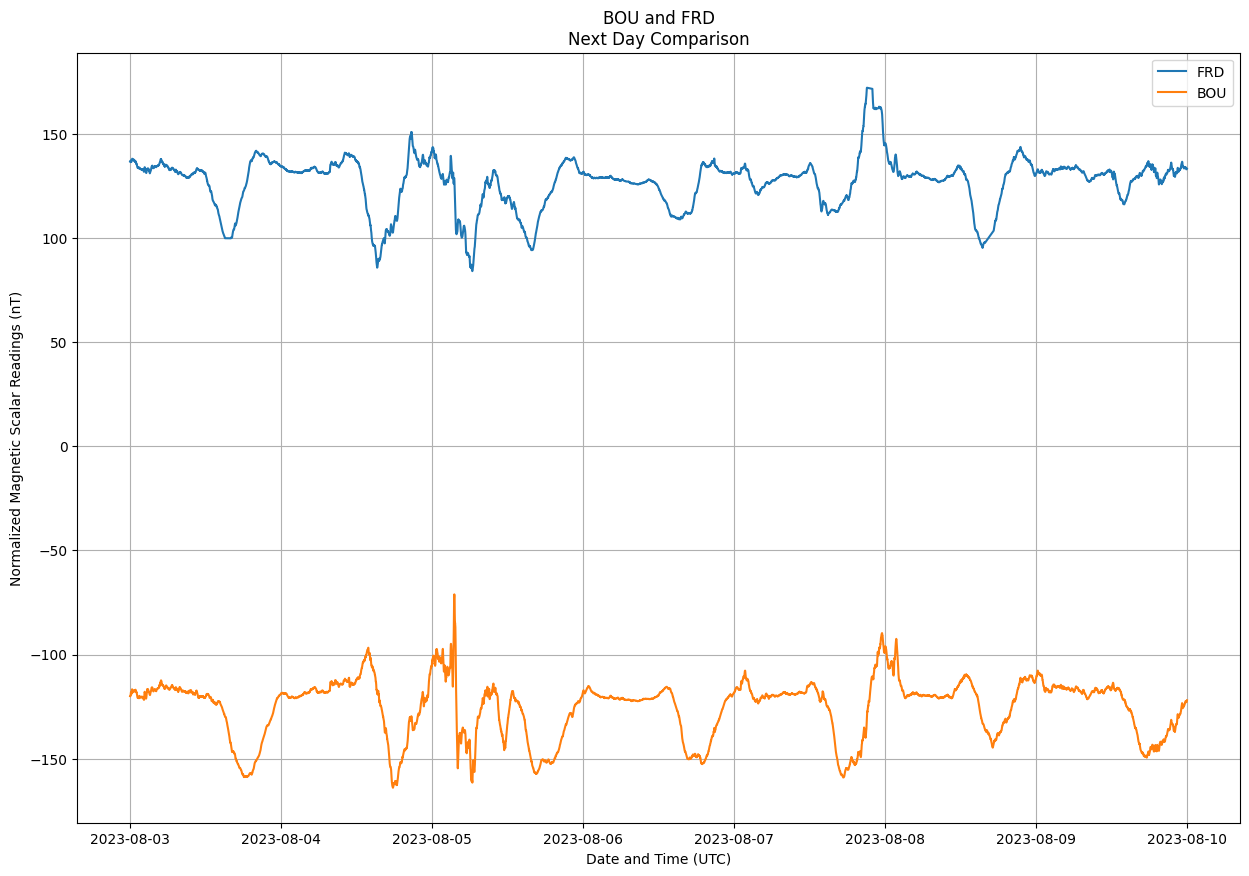

In [10]:
df_dict = pi.loadInterMagData(EXAM_DIR, second=False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df_pred   = df_dict[to_name]

to_df_pred = pu.reject_outliers(to_df_pred,
                           window_size=2000,
                           std_lim=3)

to_IGRF_f   = np.array(to_df_pred.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df_pred.F)
from_f = np.array(from_df.F)
    
to_f_no_core_pred   = np.array(to_df_pred.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df_pred.epoch_sec)
from_t = np.array(from_df.epoch_sec)


plt.figure()
plt.title(from_name + ' and ' + to_name + '\nNext Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df_pred.datetime, to_f_no_core_pred, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()


from_combined_t_pred, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second=False)
from_combined_f_no_core_pred = from_combined_f - from_IGRF_f


interp_combined = interpolate.interp1d(from_combined_t_pred, from_combined_f_no_core_pred, 'cubic')

interp_mask_pred = np.logical_and(to_t >= from_combined_t_pred.min(), to_t <= from_combined_t_pred.max())
interp_t_pred    = to_t[interp_mask_pred] # Clip interpolation times

from_combined_interp_pred = interp_combined(interp_t_pred)

print([offset, scale])
from_combined_opt_f_pred = Diurnal.apply_cal([offset, scale], from_combined_f_no_core_pred)

# Create Neural Net Prediction Data Set: 
test_loader, test_ds, Xts, yts = ERSM_ensemble[0].process_testing_data(interp_t_pred, from_combined_interp_pred, to_f_no_core_pred[interp_mask_pred])
for i in range(num_model):
    ERSM_ensemble[i].process_testing_data(interp_t_pred, from_combined_interp_pred, to_f_no_core_pred[interp_mask_pred])

# Training Neural Net

In [11]:
# TODO Run Training Code: 
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch import sqrt

lr = 7.5e-1
num_epoch = 300 # Change this later 


loss_hist = []
val_rmse_hist = []

# TODO
# opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()



for model in ERSM_ensemble:
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) # Create optimizer with selected learning rate
    #opt = optim.ASGD(model.parameters(), lr=lr, weight_decay=0.01)
    
    scheduler = ExponentialLR(opt, gamma=0.96)
    
    a_tr_loss = []
    a_tr_rmse = []
    a_ts_loss = []
    a_ts_rmse = []

    for epoch in range(num_epoch):
        model.train() # Model is set in training mode
        sum_rmse = 0 # initialize correct counter
        total = 0 # initialize total counter

        batch_loss_tr = [] # Array to store loss for each batch
        for train_iter, data in enumerate(train_loader):
            x_batch,y_batch = data # separate input and outputs
            #y_batch = y_batch.type(torch.long) 
            out = model(x_batch)

            loss = criterion(out,y_batch) #criterion for predicted vs truth
            batch_loss_tr.append(loss.item()) # Add Loss to batch loss


            # Compute gradients using back propagation
            opt.zero_grad() # Sets all gradients to 0
            loss.backward() # Apply backwards propogation to calculate gradient

            # Take an optimization 'step'
            opt.step()
            sum_rmse += loss.item()*y_batch.size()[0]
            total += y_batch.size()[0]

        a_tr_loss.extend(batch_loss_tr) # Add batch losses to a_tr_loss
        a_tr_rmse.append(np.sqrt(sum_rmse/total)) # Add Average RMSE Over Epoch
    
        if epoch >= 100:
            scheduler.step()
        
        model.eval() # put model in evaluation mode

        sum_rmse = 0 # Reset correct number counter
        total = 0 # Reset total counter

        batch_loss_ts = []
        with torch.no_grad():
            # Why is test set not calculated all at once - why do we use a for loop? 
            for data in test_loader:
                Xts_nn, yts_nn = data # Separate test data
                #yts_nn = yts_nn.type(torch.long) 
                outputs = model(Xts_nn) #Get predictions

                test_loss = criterion(outputs,yts_nn).item()
                batch_loss_ts.append(test_loss) #Get loss of predictions

                sum_rmse += loss.item()*yts_nn.size()[0]
                total += yts_nn.size()[0]

        a_ts_loss.append(np.mean(batch_loss_ts)) # Is average of losses = loss if test_set was done all at once
        a_ts_rmse.append(np.sqrt(sum_rmse/total)) # Calculate accuracy for fold
        
        if(epoch%10==0):
            print('Epoch {0:d}: RMSE {1:.4f}'.format(epoch, np.sqrt(sum_rmse/total)))
        
    loss_hist.append(a_tr_loss)
    val_rmse_hist.append(a_ts_rmse)


Epoch 0: RMSE 20.6154
Epoch 10: RMSE 6.9658
Epoch 20: RMSE 6.0846
Epoch 30: RMSE 6.1949
Epoch 40: RMSE 6.1971
Epoch 50: RMSE 6.6695
Epoch 60: RMSE 6.0128
Epoch 70: RMSE 5.6601
Epoch 80: RMSE 6.6026
Epoch 90: RMSE 5.9774
Epoch 100: RMSE 5.6788
Epoch 110: RMSE 5.8346
Epoch 120: RMSE 5.4148
Epoch 130: RMSE 5.6006
Epoch 140: RMSE 5.4551
Epoch 150: RMSE 5.3835
Epoch 160: RMSE 5.3456
Epoch 170: RMSE 5.6022
Epoch 180: RMSE 5.1313
Epoch 190: RMSE 5.2057
Epoch 200: RMSE 5.0607
Epoch 210: RMSE 5.0262
Epoch 220: RMSE 5.1694
Epoch 230: RMSE 5.2081
Epoch 240: RMSE 5.2676
Epoch 0: RMSE 25.5555
Epoch 10: RMSE 6.9032
Epoch 20: RMSE 6.7391
Epoch 30: RMSE 6.2902
Epoch 40: RMSE 6.1053
Epoch 50: RMSE 6.1576
Epoch 60: RMSE 6.2748
Epoch 70: RMSE 6.0881
Epoch 80: RMSE 6.3465
Epoch 90: RMSE 6.3918
Epoch 100: RMSE 6.5154
Epoch 110: RMSE 5.6895
Epoch 120: RMSE 5.8138
Epoch 130: RMSE 5.4479
Epoch 140: RMSE 5.4882
Epoch 150: RMSE 5.4169
Epoch 160: RMSE 5.1107
Epoch 170: RMSE 5.0683
Epoch 180: RMSE 5.0116
Epoch 19

# Model Performance over Epoch

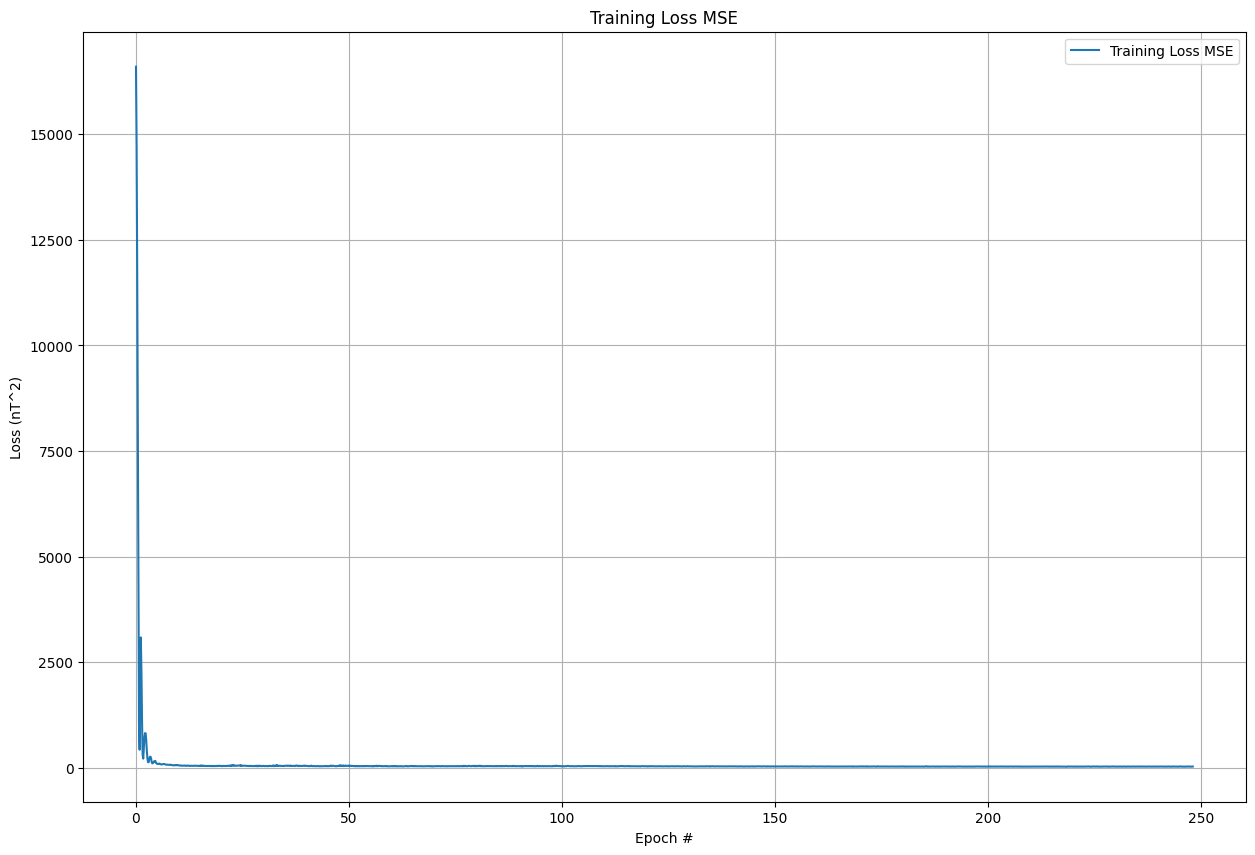

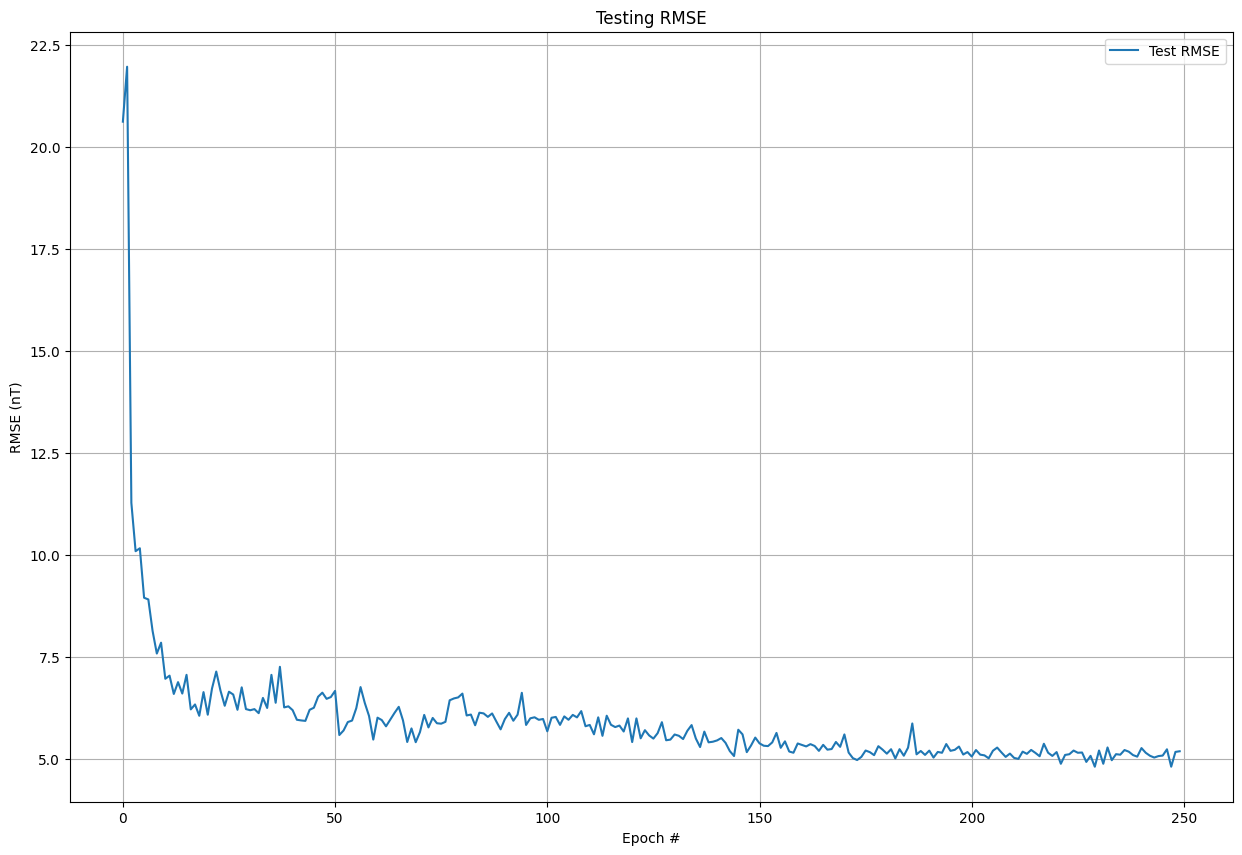

In [12]:

num_batch = len(loss_hist[0])
epoch = np.arange(num_batch)*batch_size/len(train_loader.dataset)

plt.figure()
plt.plot(epoch,loss_hist[0],label = 'Training Loss MSE')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Loss (nT^2)')
plt.title('Training Loss MSE')
plt.grid()

epoch = range(num_epoch)
plt.figure()
plt.plot(epoch,val_rmse_hist[0],label = 'Test RMSE')
plt.title('Testing RMSE')
plt.xlabel('Epoch #')
plt.ylabel('RMSE (nT)')
plt.grid()
plt.legend()

# Utility Ensemble Prediction Method

In [20]:
def make_prediction(data, ensemble_models):
    #Get Number of Samples From Data Tensor
    num_pred = data.size(dim=0)
    #Get Number of Models
    num_model = len(ensemble_models)
    #Use shape to create np.empty matrix 
    all_preds = np.empty((num_model,num_pred))
    #print(all_preds.shape, all_preds)
    with torch.no_grad():
        for i in range(num_model):
            all_preds[i,:] = np.hstack(ensemble_models[i](data).numpy())
            all_preds[i,:] = filt.lpf(all_preds[i,:], 1/(24*50), 1/60)
        #Make and filter predictions here for each model: 
        #Replace Row of np Array
    all_preds = np.sort(all_preds, axis = 0) # Sort With Respect to Each Samples
    #print(all_preds.shape, all_preds)
    
    preds = []
    flag = False
    for i in range(num_pred):
        model_preds = all_preds[:,i].T
        median = model_preds[int(num_model/2)]
        if num_model % 2 == 0:
            median = (model_preds[int(num_model/2)] + model_preds[int(num_model/2)+1])/2
        
        #print(median)
        min_dist = median - model_preds[0]
        max_dist = model_preds[num_model - 1] - median
        #print(median, min_dist, max_dist)
        
        if flag:
            preds.append(np.mean(model_preds))
        elif min_dist > max_dist:
            preds.append(np.mean(model_preds[1:])) # average all but min
            #print('\t0')
        else:
            preds.append(np.mean(model_preds[:num_model-1])) #average all but max
            #print('\t1')
            
    return preds

    # For the array Sort (in vertical axis)
    
    # Compute Distance Between median, max, and median,min for each one (Median Element is middle for odd number, and proceed to remove the bad element )

# Comparison (Training)

(14262,) (14262,)
(14262,) (14262,)
(14262,) (14262,)
(14262,) (14262,)
(14262,) (14262,)
(14262,) (14262,)
RMSE linear: 10.003965055610095
RMSE knn: 4.692922462323412
RMSE linear: [11.028985777626353, 10.920598120228956, 12.756437789794997, 4.977966043459599, 7.333965839532793, 9.242781349730732, 8.397729172473614, 9.737027943964604, 6.501056385521443, 15.396288025401518]
RMSE knn: [4.555797172024879, 6.746993274905979, 7.3709257047036045, 3.608428964366445, 2.6814118439690895, 4.875054265339015, 3.155150219503736, 4.9769702345550435, 2.81558264522778, 3.628985217197715]
RMSE linear Kp [<4, >=4]: [9.90466006157353, 11.783750344314162]
RMSE knn: Kp [<4, >=4] [4.703286680286194, 4.4847988797295875]


1

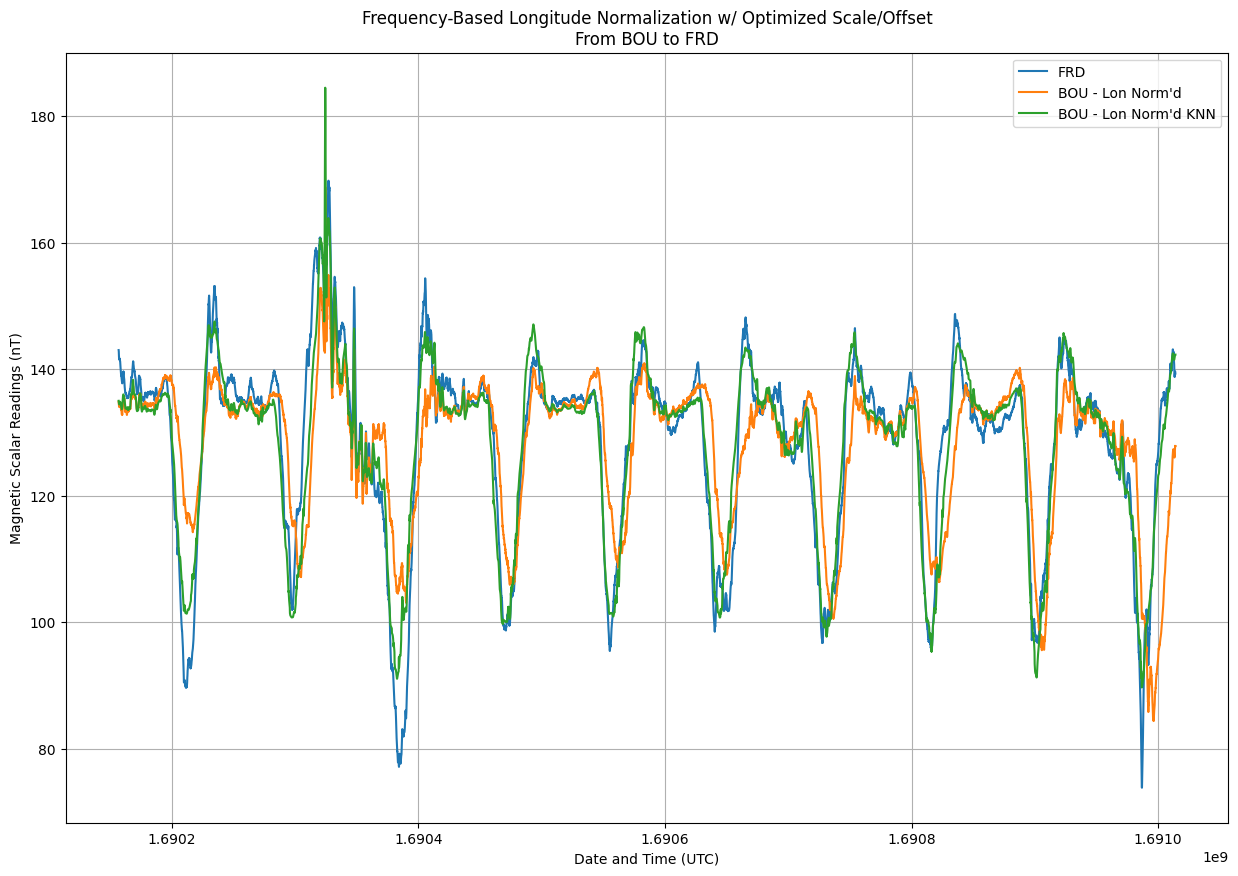

In [14]:

original_data = ERSM_ensemble[0].x_tensor(from_combined_t, from_combined_f_no_core)
prediction = make_prediction(original_data, ERSM_ensemble)
 # TODODODO_______________________________________-----------------------------------

plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} - Lon Norm\'d KNN'.format(from_name))
plt.legend()
plt.grid()



# Calculate Root Mean Square Error
rmse_linear= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f)
rmse_knn= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction)

rmse_linear_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'day')
rmse_knn_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'day')

rmse_kp_linear = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'Kp')
rmse_kp_knn = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'Kp')

print('RMSE linear:', rmse_linear)
print('RMSE knn:', rmse_knn)

print('RMSE linear:', rmse_linear_broken)
print('RMSE knn:', rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', rmse_kp_knn)


first_data_list = [from_name, to_name, start_tra, end_tra, offset, scale, rmse_linear, rmse_knn]
first_data_list.extend(rmse_linear_broken)
first_data_list.extend(rmse_knn_broken)
first_data_list.extend(rmse_kp_linear)
first_data_list.extend(rmse_kp_knn)
out_file.write(','.join(map(str,first_data_list)))
out_file.write(',')


# Comparison (Prediction)

# Test Optimal Parameters for Next Day's Data

(9968,) (9968,)
(9968,) (9968,)
RMSE linear: 8.573295687949367
RMSE knn: 8.539163490808916
(9968,) (9968,)
(9968,) (9968,)
(9968,) (9968,)
(9968,) (9968,)
RMSE linear: [8.440685823640694, 8.55529058122679, 12.048098160039958, 6.45191592222426, 7.28077810002471, 6.391266743822117, 9.22990996337899]
RMSE knn: [5.5754481938816545, 6.276756013753475, 13.044958150830919, 5.685738330525316, 8.766838423346538, 5.482624896789915, 11.356429187596607]
RMSE linear Kp [<4, >=4]: [7.545682134212265, 12.693893103050964]
RMSE knn: Kp [<4, >=4] [7.257143909181306, 13.418557820852547]


ValueError: I/O operation on closed file.

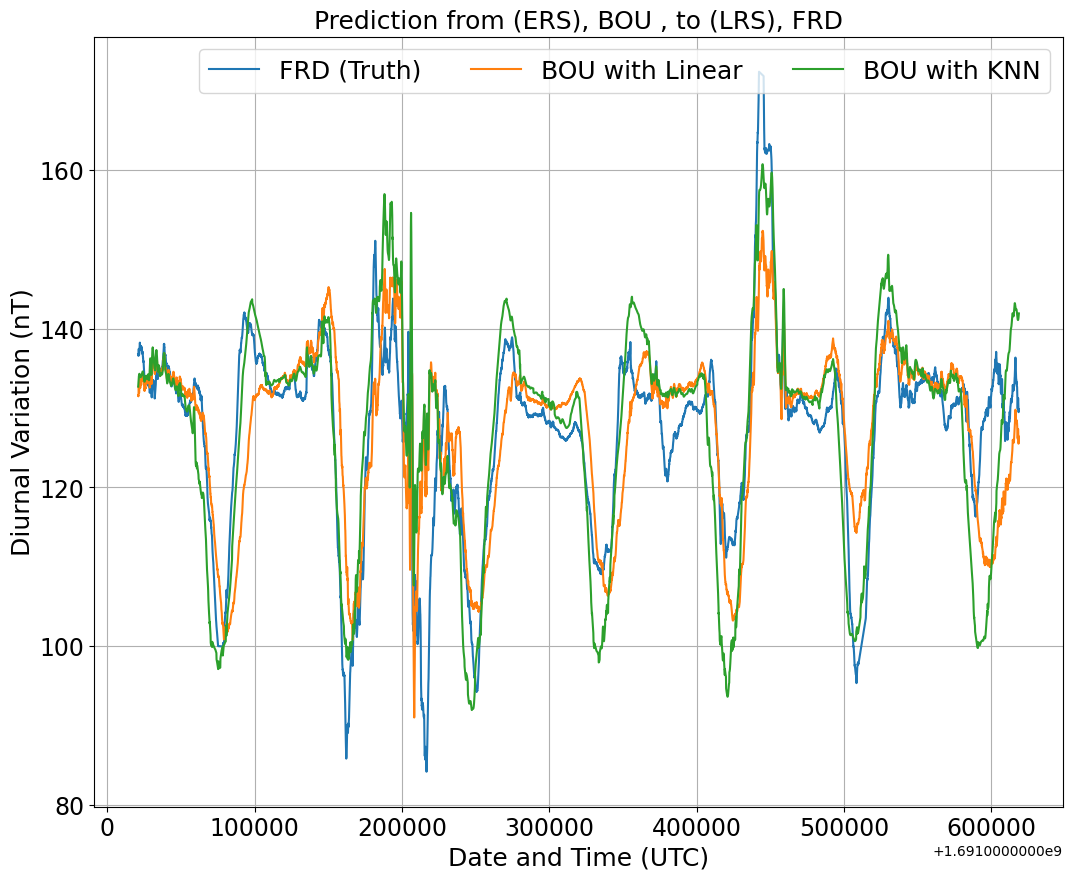

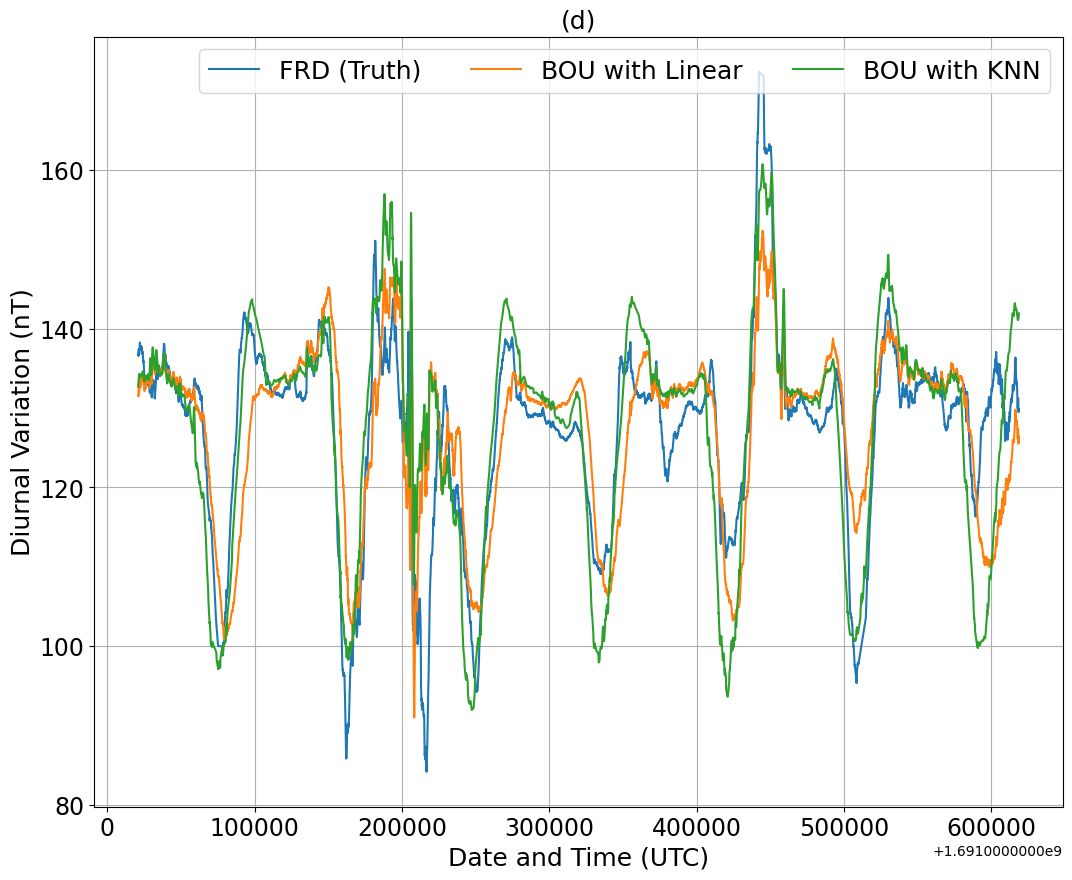

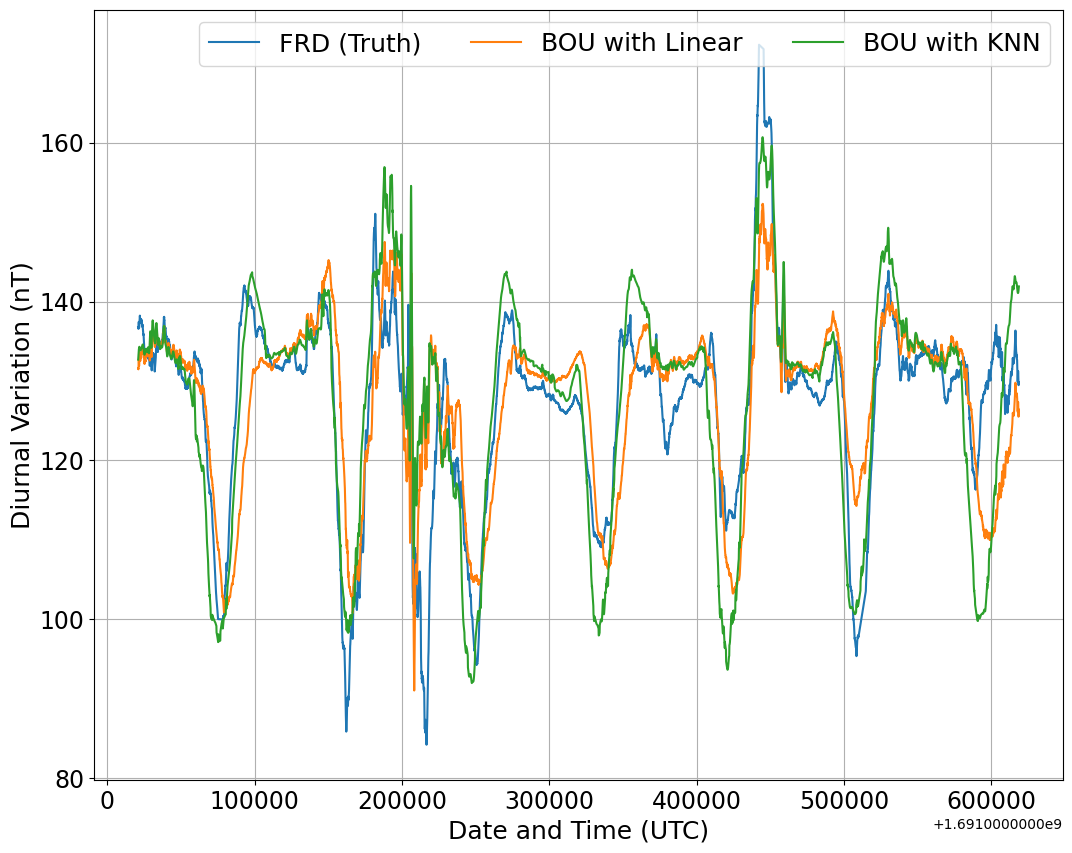

In [21]:
pred_data = ERSM_ensemble[0].x_tensor(from_combined_t_pred, from_combined_f_no_core_pred)
prediction_pred = make_prediction(pred_data, ERSM_ensemble)

font = 18
plt.figure(figsize = (12.5,10))
plt.title('Prediction from (ERS), ' + from_name  +  ' , to (LRS), ' + to_name, fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol=3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.title('(d)', fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

# Calculate Root Mean Square Error
next_rmse_linear= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred)
next_rmse_knn= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred)

print('RMSE linear:', next_rmse_linear)
print('RMSE knn:', next_rmse_knn)


next_rmse_linear_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'day')
next_rmse_knn_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'day')

next_rmse_kp_linear = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'Kp')
next_rmse_kp_knn = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'Kp')

print('RMSE linear:', next_rmse_linear_broken)
print('RMSE knn:', next_rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', next_rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', next_rmse_kp_knn)

second_data_list = [start_tst, end_tst, next_rmse_linear, next_rmse_knn]
second_data_list.extend(next_rmse_linear_broken)
second_data_list.extend(next_rmse_knn_broken)
second_data_list.extend(next_rmse_kp_linear)
second_data_list.extend(next_rmse_kp_knn)
out_file.write(','.join(map(str,second_data_list)))
out_file.write('\n')
out_file.close()